In [12]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label
from skimage.feature import hog

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from glob import glob

def read_image(name):
    return cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB)

cars_images = {'train': glob("vehicles/*/train/*.png"), 'test': glob("vehicles/*/test/*.png")}
not_cars_images = {'train': glob("non-vehicles/*/train/*.png"), 'test': glob("non-vehicles/*/test/*.png")}

In [14]:
from numpy.random import randint

car_image = read_image(cars_images['train'][0])
not_car_image = read_image(not_cars_images['train'][0])

In [15]:
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = cv2.calcHist([img], [0], None, [nbins], [0,256])
    channel2_hist = cv2.calcHist([img], [1], None, [nbins], [0,256])
    channel3_hist = cv2.calcHist([img], [2], None, [nbins], [0,256])
    hist_features = np.concatenate((channel1_hist, channel2_hist, channel3_hist))
    return hist_features

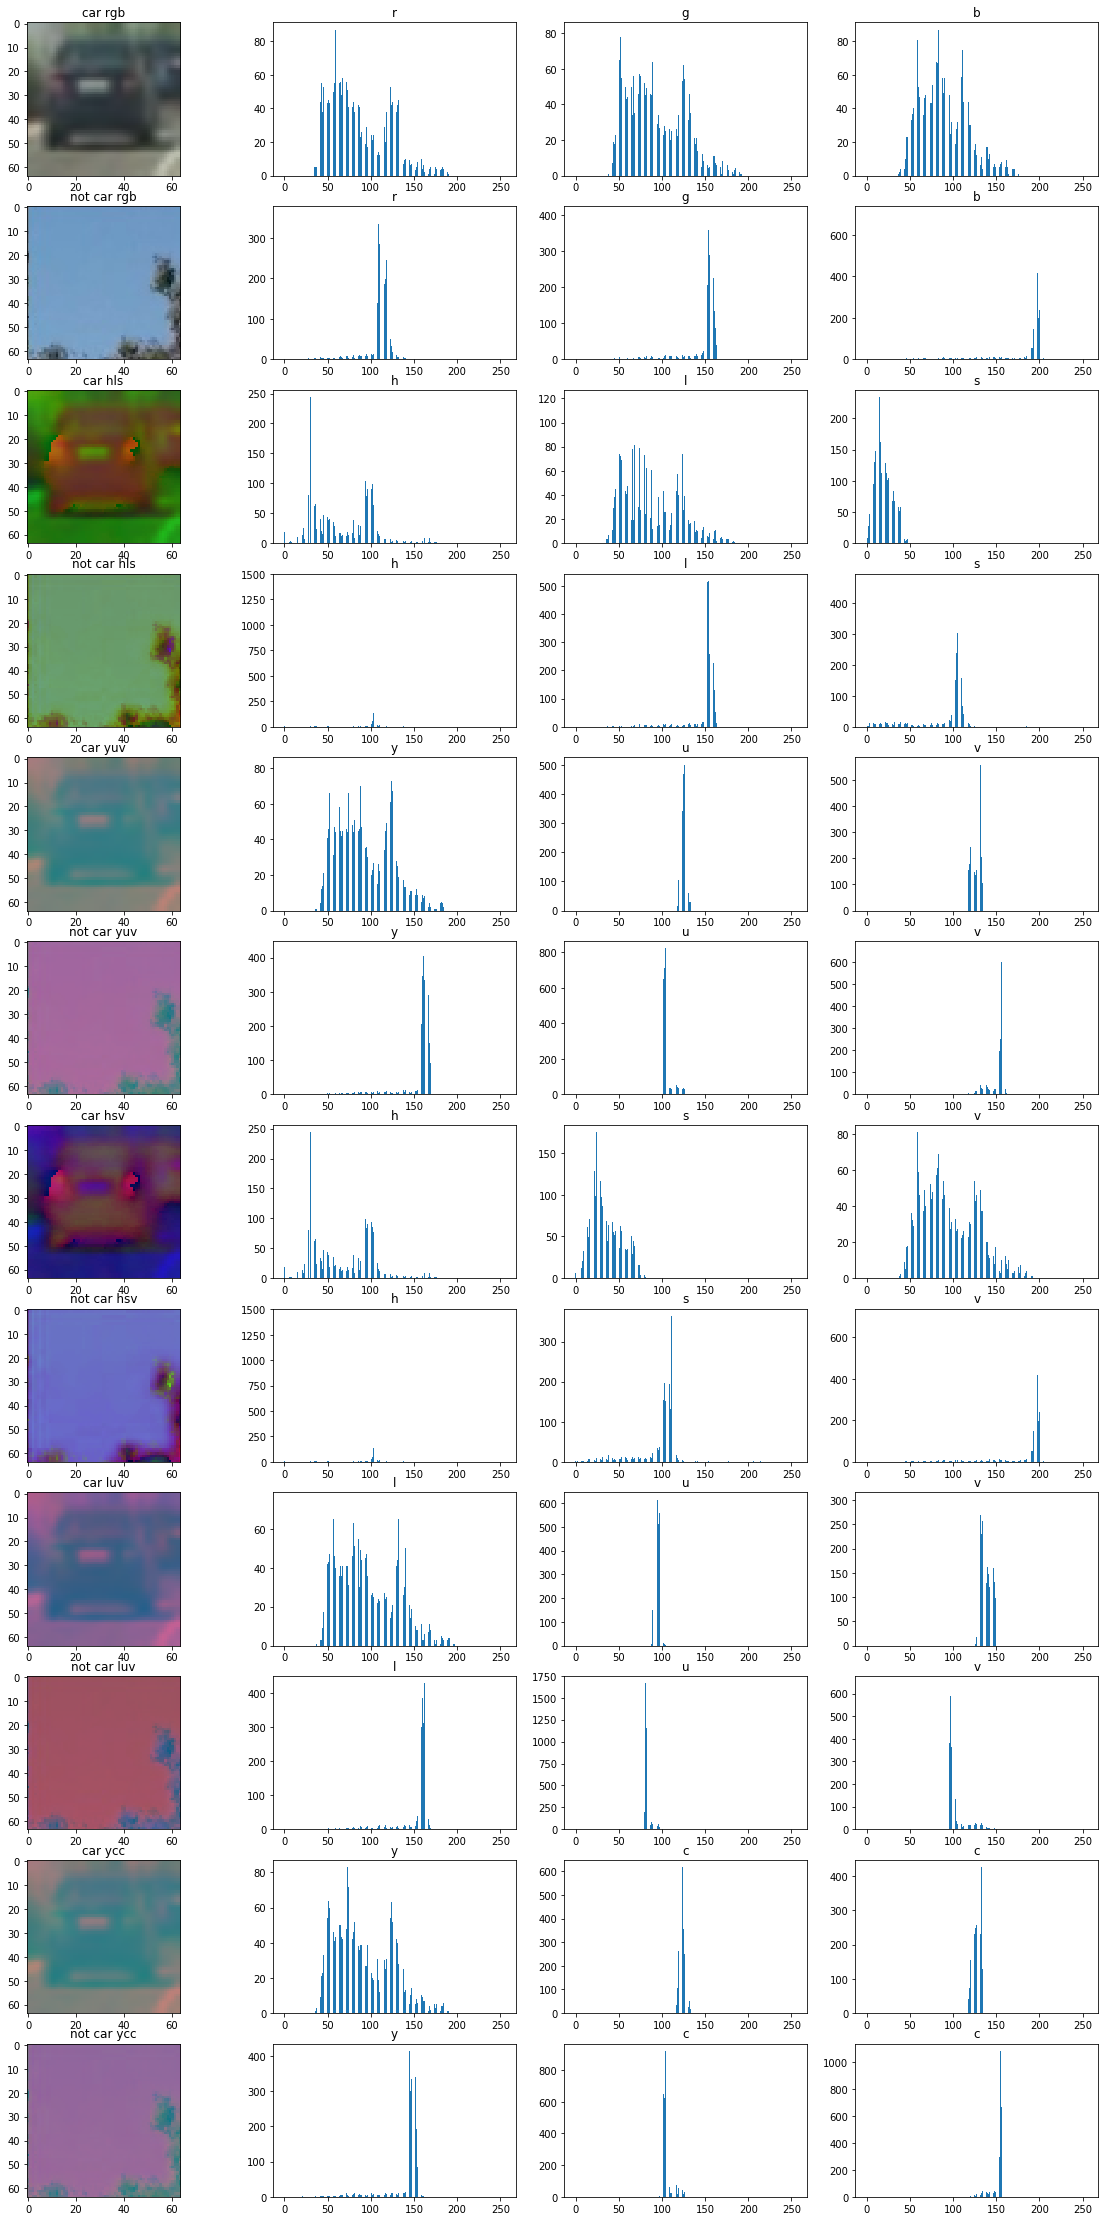

In [16]:
rgb_car = car_image
hls_car = cv2.cvtColor(car_image, cv2.COLOR_RGB2HLS)
yuv_car = cv2.cvtColor(car_image, cv2.COLOR_RGB2YUV)
hsv_car = cv2.cvtColor(car_image, cv2.COLOR_RGB2HSV)
luv_car = cv2.cvtColor(car_image, cv2.COLOR_RGB2LUV)
ycc_car = cv2.cvtColor(car_image, cv2.COLOR_RGB2YCrCb)

cars = [rgb_car, hls_car, yuv_car, hsv_car, luv_car, ycc_car]

rgb_not_car = not_car_image
hls_not_car = cv2.cvtColor(not_car_image, cv2.COLOR_RGB2HLS)
yuv_not_car = cv2.cvtColor(not_car_image, cv2.COLOR_RGB2YUV)
hsv_not_car = cv2.cvtColor(not_car_image, cv2.COLOR_RGB2HSV)
luv_not_car = cv2.cvtColor(not_car_image, cv2.COLOR_RGB2LUV)
ycc_not_car = cv2.cvtColor(not_car_image, cv2.COLOR_RGB2YCrCb)

not_cars = [rgb_not_car, hls_not_car, yuv_not_car, hsv_not_car, luv_not_car, ycc_not_car]
spaces = ['rgb', 'hls', 'yuv', 'hsv', 'luv', 'ycc']

nbins = 256

plt.figure(figsize=(20, 40))
for i in range(len(cars)):
    car = cars[i]
    not_car = not_cars[i]
    space = spaces[i]
    
    car_hist = color_hist(car, nbins=nbins)
    not_car_hist = color_hist(not_car, nbins=nbins)
    
    plots = [car, car_hist[0:nbins], car_hist[nbins:2*nbins], car_hist[2*nbins:3*nbins], not_car, not_car_hist[0:nbins], not_car_hist[nbins:2*nbins], not_car_hist[2*nbins:3*nbins]]
    title = ["car " + space, space[0], space[1], space[2], "not car " + space, space[0], space[1], space[2]]
    
    for j in range(len(plots)):
        img = plots[j]
        text = title[j]
        
        plt.subplot(2 * len(cars), 4, 8 * i + j + 1)
        if j % 4 == 0:
            plt.imshow(img)
        else:
            plt.bar(range(0, nbins), img, width=0.5)
            
        plt.title(text)
        
plt.show()        

In [18]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis:
        vis = []
        for i in range(img.shape[2]):
            vis.append(
                hog(img[:, :, i], 
                    orientations=orient, 
                    pixels_per_cell=(pix_per_cell, pix_per_cell),
                    cells_per_block=(cell_per_block, cell_per_block),
                    visualise=True)[1])
        return np.stack(vis, axis=2)
    else:
        features = []
        for i in range(img.shape[2]):
            features.append(
                hog(img[:, :, i], 
                    orientations=orient, 
                    pixels_per_cell=(pix_per_cell, pix_per_cell),
                    cells_per_block=(cell_per_block, cell_per_block)))
        return np.concatenate(features)

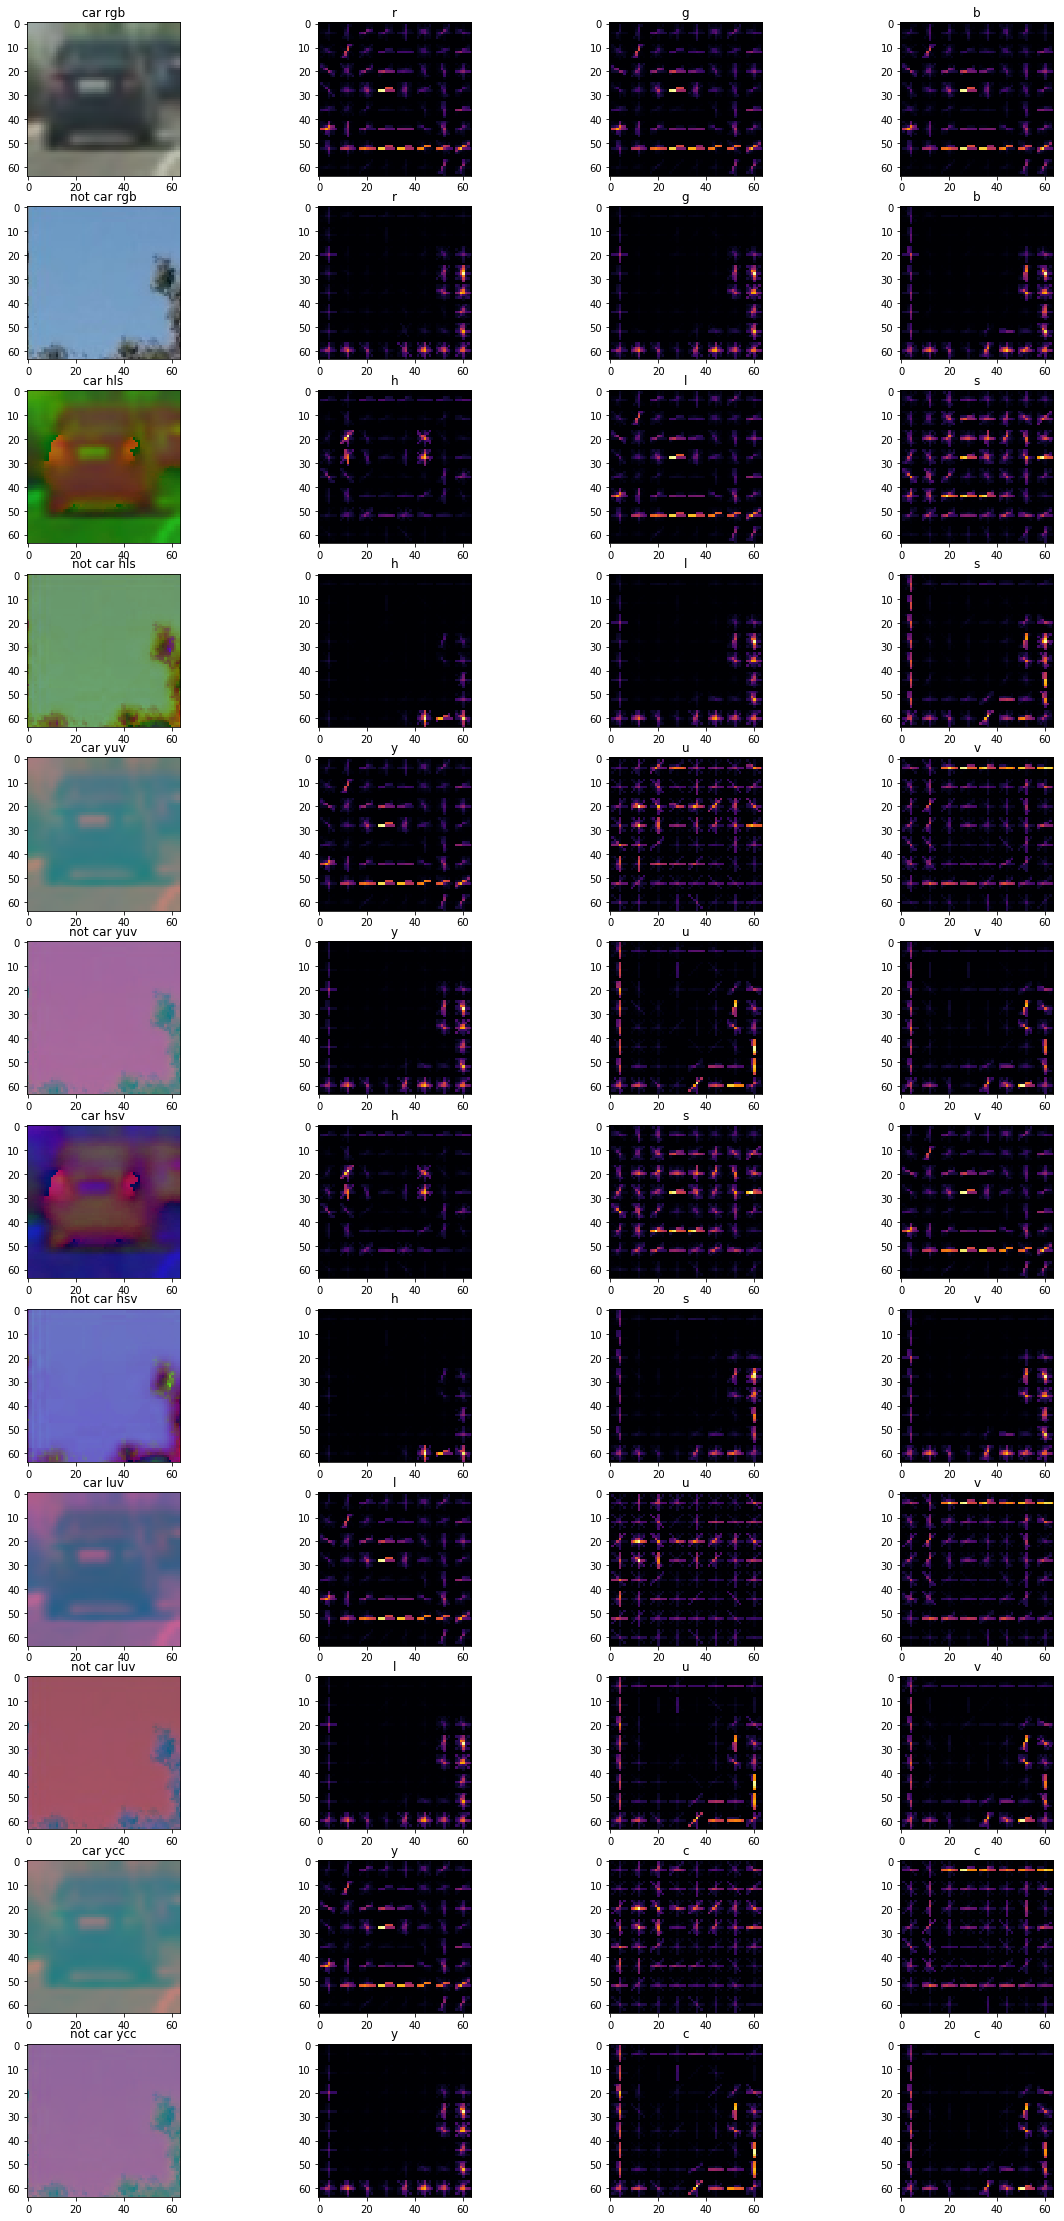

In [19]:
orient = 12      # HOG orientations
pix_per_cell = 8   # HOG pixels per cell
cell_per_block = 2 # HOG cells per block

plt.figure(figsize=(20, 40))
for i in range(len(cars)):
    car = cars[i]
    not_car = not_cars[i]
    space = spaces[i]
    
    car_hogs = get_hog_features(car, orient, pix_per_cell, cell_per_block, vis=True)
    not_car_hogs = get_hog_features(not_car, orient, pix_per_cell, cell_per_block, vis=True)
    
    plots = [car, car_hogs[:, :, 0], car_hogs[:, :, 1], car_hogs[:, :, 2], not_car, not_car_hogs[:, :, 0], not_car_hogs[:, :, 1], not_car_hogs[:, :, 2]]
    title = ["car " + space, space[0], space[1], space[2], "not car " + space, space[0], space[1], space[2]]
    
    for j in range(len(plots)):
        img = plots[j]
        text = title[j]
        
        plt.subplot(2 * len(cars), 4, 8 * i + j + 1)
        plt.imshow(img, cmap="inferno")
        plt.title(text)
        
plt.show()        

In [24]:
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

In [25]:
def extract_features(
    imgs,
    color_space='HLS',
    spatial_size=(16, 16),
    hist_bins=32, 
    orient=12, 
    pix_per_cell=16, 
    cell_per_block=2, 
    hog_channel='ALL',
    spatial_feat=True, 
    hist_feat=True, 
    hog_feat=True):
    
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(np.ravel(hist_features))
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(hog(
                        feature_image[:,:,channel], 
                        orientations=orient,
                        pixels_per_cell=(pix_per_cell, pix_per_cell),
                        cells_per_block=(cell_per_block, cell_per_block)))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [26]:
car_features = {
    'train': extract_features([read_image(name) for name in cars_images['train']]),
    'test':  extract_features([read_image(name) for name in cars_images['test']])
}
                   
not_car_features = {
   'train': extract_features([read_image(name) for name in not_cars_images['train']]),
   'test':  extract_features([read_image(name) for name in not_cars_images['test']])
}
X = np.vstack((car_features['train'], car_features['test'], not_car_features['train'], not_car_features['test'])).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
                   
X_train = X_scaler.transform(np.vstack((car_features['train'], not_car_features['train'])))
y_train = np.hstack((np.ones(len(car_features['train'])), np.zeros(len(not_car_features['train']))))
X_test = X_scaler.transform(np.vstack((car_features['test'], not_car_features['test'])))
y_test = np.hstack((np.ones(len(car_features['test'])), np.zeros(len(not_car_features['test']))))

X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

print("Train features: %d; test features: %d." % (len(X_train), len(X_test)))

Train features: 14224; test features: 3536.


In [27]:
X_fit_train = X_train[:len(X_train) // 10]
y_fit_train = y_train[:len(y_train) // 10]
X_fit_test  = X_test[:len(X_test) // 10]
y_fit_test  = y_test[:len(y_test) // 10]

In [28]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

params = [
  {'C': [1, 10, 100], 'kernel': ['linear']},
  {'C': [1, 10, 100], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
  {'C': [1, 10, 100], 'degree': [2, 3, 4], 'kernel': ['poly']},
  {'C': [1, 10, 100], 'kernel': ['sigmoid']}  
]

svc = svm.SVC()
svc = GridSearchCV(svc, params)
svc.fit(X_fit_train, y_fit_train)
pred = svc.predict(X_fit_test)
svc_acc = accuracy_score(y_fit_test, pred)

print("SVC accuracy on the validation test: %.3f" % svc_acc)

SVC accuracy on the validation test: 0.992


In [29]:
print("SVC best params are: ")
print(svc.best_params_)

SVC best params are: 
{'gamma': 0.0001, 'kernel': 'rbf', 'C': 1}


In [30]:
from sklearn.tree import DecisionTreeClassifier
    
dtc = DecisionTreeClassifier()
dtc.fit(X_fit_train, y_fit_train)

pred = dtc.predict(X_fit_test)
dtc_acc = accuracy_score(y_fit_test, pred)

print("DTC accuracy on the validation test: %.3f" % dtc_acc)

DTC accuracy on the validation test: 0.938


In [31]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_fit_train, y_fit_train)
pred = nb.predict(X_fit_test)
nb_acc = accuracy_score(y_fit_test, pred)

print("NB accuracy on the validation test: %.3f" % nb_acc)

NB accuracy on the validation test: 0.972


In [167]:
from sklearn import svm

clf = svm.LinearSVC()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
clf_acc = accuracy_score(y_test, pred)

print("Classifier accuracy: %.3f" % clf_acc)

Classifier accuracy: 0.982


In [41]:
import glob

test_images = []
for image in glob.glob("test_images/*"):
    test_images.append(cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB))

In [80]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def slide_window(img, ystart, ystop, scale=1, pix_per_cell=8, cell_per_block=2):
    
    # Define blocks and steps as above
    nxblocks = (img.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = ((ystop - ystart) // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            xleft = int(xpos * pix_per_cell * scale)
            ytop = int(ystart + ypos * pix_per_cell * scale)
            step = int(window * scale)

            windows.append(((xleft, ytop), (xleft + step, ytop + step)))
                
    return windows

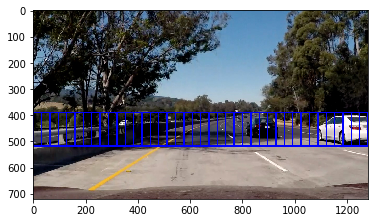

In [168]:
img = np.copy(test_images[4])
windows = []
#windows += slide_window(img, 400, 480, 1.1)
windows += slide_window(img, 390, 470, 2)
#windows += slide_window(img, 385, 470, 3)
for window in windows:
    cv2.rectangle(img, window[0], window[1], (0, 0, 255), 3)

plt.imshow(img)
plt.show()

In [169]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [170]:
def detection(image):
    patches = []
    for j, box in enumerate(boxes):
        patch = image[box[0][1]:box[1][1], box[0][0]:box[1][0]]
        if patch.shape[0] == 0 or patch.shape[1] == 0:
            continue
        patch = cv2.resize(patch, (64, 64))
        patches.append(patch)
    
    features = extract_features(patches)
    features = X_scaler.transform(features)
    pred = clf.predict(features)
    indices = np.where(pred == 1)
    preds = np.array(boxes)[indices]
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, preds)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 0)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    return draw_labeled_bboxes(np.copy(image), labels)

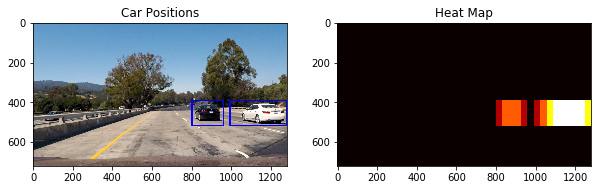

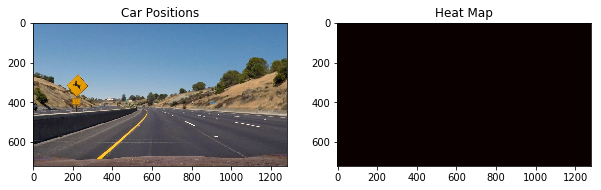

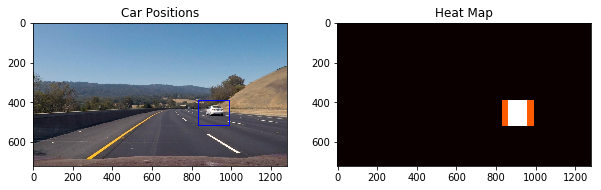

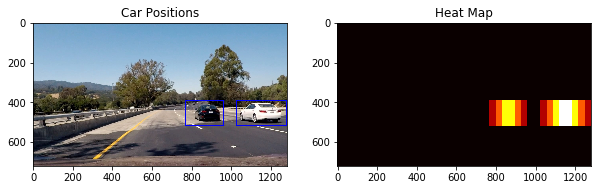

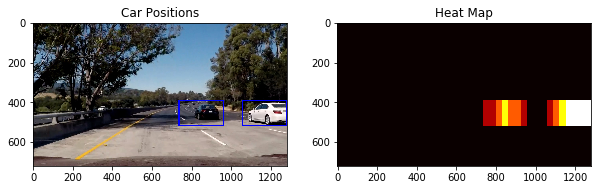

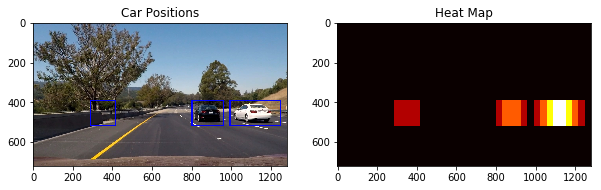

In [171]:
boxes = windows

for i in range(len(test_images)):
    image = test_images[i]
    
    patches = []
    for j, box in enumerate(boxes):
        patch = image[box[0][1]:box[1][1], box[0][0]:box[1][0]]
        if patch.shape[0] == 0 or patch.shape[1] == 0:
            continue
        patch = cv2.resize(patch, (64, 64))
        patches.append(patch)
    
    features = extract_features(patches)
    features = X_scaler.transform(features)
    pred = clf.predict(features)
    indices = np.where(pred == 1)
    preds = np.array(boxes)[indices]
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, preds)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 0)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    fig = plt.figure(figsize=(10, 20))
    plt.subplot(len(test_images), 2, 2 * i + 1)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(len(test_images), 2, 2 * i + 2)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    
plt.show()

In [173]:
def draw_windows(img):
    for window in windows:
        cv2.rectangle(img, window[0], window[1], (0, 0, 255), 1)
    return img

from moviepy.editor import VideoFileClip

output = 'project_video_result.mp4'
clip = VideoFileClip("project_video.mp4")
clip = clip.fl_image(detection)
clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<02:46,  7.59it/s]

  0%|          | 2/1261 [00:00<02:48,  7.48it/s]

  0%|          | 3/1261 [00:00<02:47,  7.52it/s]

  0%|          | 4/1261 [00:00<02:45,  7.61it/s]

  0%|          | 5/1261 [00:00<02:41,  7.76it/s]

  0%|          | 6/1261 [00:00<02:38,  7.92it/s]

  1%|          | 7/1261 [00:00<02:35,  8.08it/s]

  1%|          | 8/1261 [00:01<02:33,  8.19it/s]

  1%|          | 9/1261 [00:01<02:35,  8.07it/s]

  1%|          | 10/1261 [00:01<02:36,  7.97it/s]

  1%|          | 11/1261 [00:01<02:35,  8.02it/s]

  1%|          | 12/1261 [00:01<02:35,  8.02it/s]

  1%|          | 13/1261 [00:01<02:34,  8.06it/s]

  1%|          | 14/1261 [00:01<02:33,  8.10it/s]

  1%|          | 15/1261 [00:01<02:31,  8.24it/s]

  1%|▏         | 16/1261 [00:01<02:29,  8.34it/s]

  1%|▏         | 17/1261 [00:02<02:28,  8.38it/s]

  1%|▏         | 18/1261 [00:02<02:27,  8.42it/s]

  2%|▏         | 19/1261 [00:02<02:28,  8.35it/

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

